In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')

In [2]:

import pandas
import seaborn
import numpy

from analysis import load_files

In [68]:

data = load_files('../data/one')
data.head(5)

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5773,7593,1333,2863,7591,1263,1795,7594,1572,...,2864,7593,1264,1795,7595,0,one_2500k_309lux.npy,one,309,2500
1,5034,1670,17984,2032,7307,17984,5959,1750,17984,5041,...,7308,17977,5961,1752,17979,1,one_2500k_309lux.npy,one,309,2500
2,5773,7592,1334,2862,7594,1263,1794,7593,1573,5779,...,7597,1263,1793,7595,1572,2,one_2500k_309lux.npy,one,309,2500
3,1670,17984,2032,7308,17980,5962,1750,17984,5041,1672,...,17984,5961,1751,17980,5039,3,one_2500k_309lux.npy,one,309,2500
4,7591,1333,2863,7594,1264,1795,7588,1572,5777,7597,...,1264,1795,7592,1572,5777,4,one_2500k_309lux.npy,one,309,2500


In [67]:
avg = data.groupby(['filename']).agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,1207.0,1361.5,1527.0,883.0,1362.0,1527.0,1362.0,883.0,1527.5,1205.5,...,1527.0,882.5,1362.5,1528.0,1362.0,883.0,1526.5,9.5,100.0,2500.0
one_2500k_1lux.npy,11.0,12.0,13.0,10.5,12.0,13.0,12.0,10.5,13.5,11.0,...,13.0,10.5,12.0,13.0,12.0,10.5,13.0,9.5,1.0,2500.0
one_2500k_204lux.npy,2750.5,3030.0,3344.0,2084.0,3029.0,3342.0,3028.5,2083.0,3345.5,2750.5,...,3346.0,2085.0,3032.5,3342.5,3031.0,2084.5,3346.0,9.5,204.0,2500.0
one_2500k_309lux.npy,5034.0,5405.0,5868.5,3951.0,5406.0,5867.5,5404.0,3952.0,5868.5,5040.0,...,5870.0,3950.5,5406.0,5867.0,5408.5,3951.0,5871.0,9.5,309.0,2500.0
one_2500k_408lux.npy,7322.0,7756.0,8354.0,5822.0,7756.0,8353.5,7758.5,5827.0,8354.0,7320.0,...,8356.0,5825.5,7759.5,8354.0,7761.0,5827.5,8357.0,9.5,408.0,2500.0


['ch_FZ', 'ch_FY', 'ch_FXL', 'ch_F2', 'ch_F3', 'ch_F4', 'ch_F6', 'ch_F1', 'ch_F7', 'ch_F8', 'ch_F5']


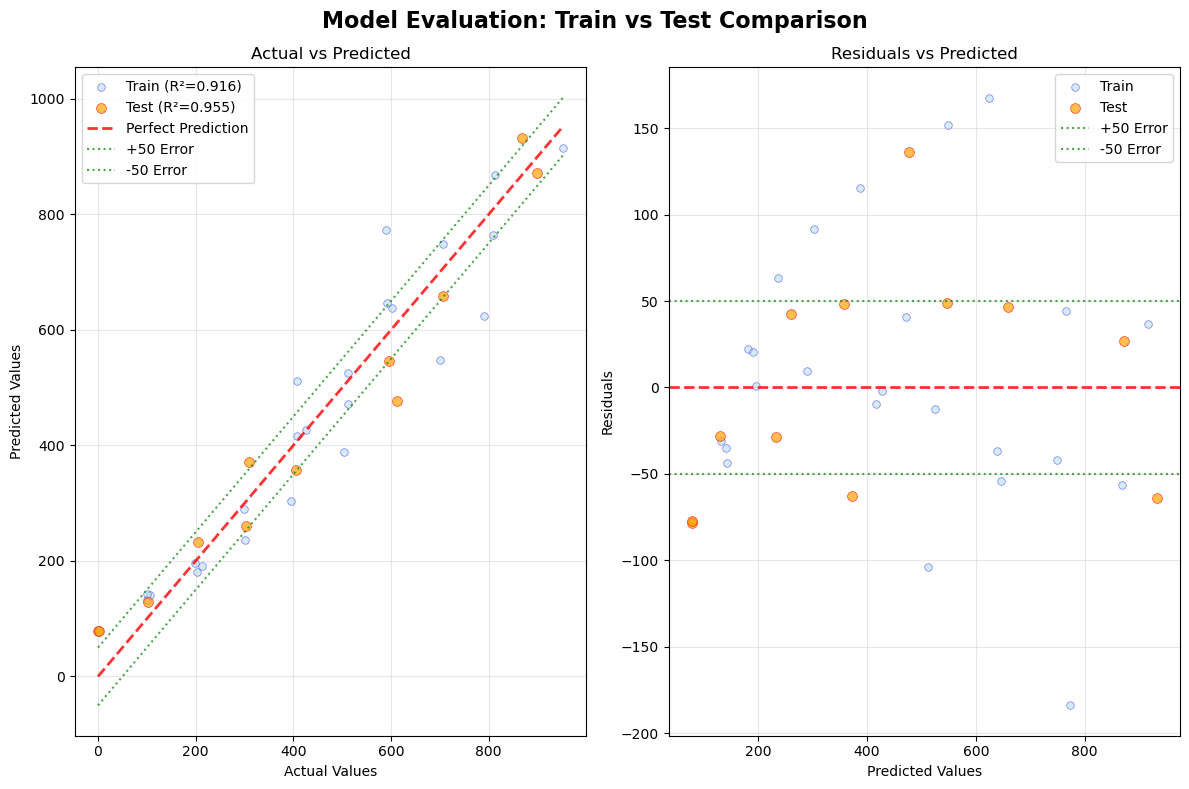


Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.9161       0.9550       0.0389      
Mean Squared Error        5877.3653    4149.4929    1727.8724   
RMSE                      76.6640      64.4166      12.2474     
Mean Absolute Error       58.8137      57.4233      1.3905      
Sample Size               26           12          


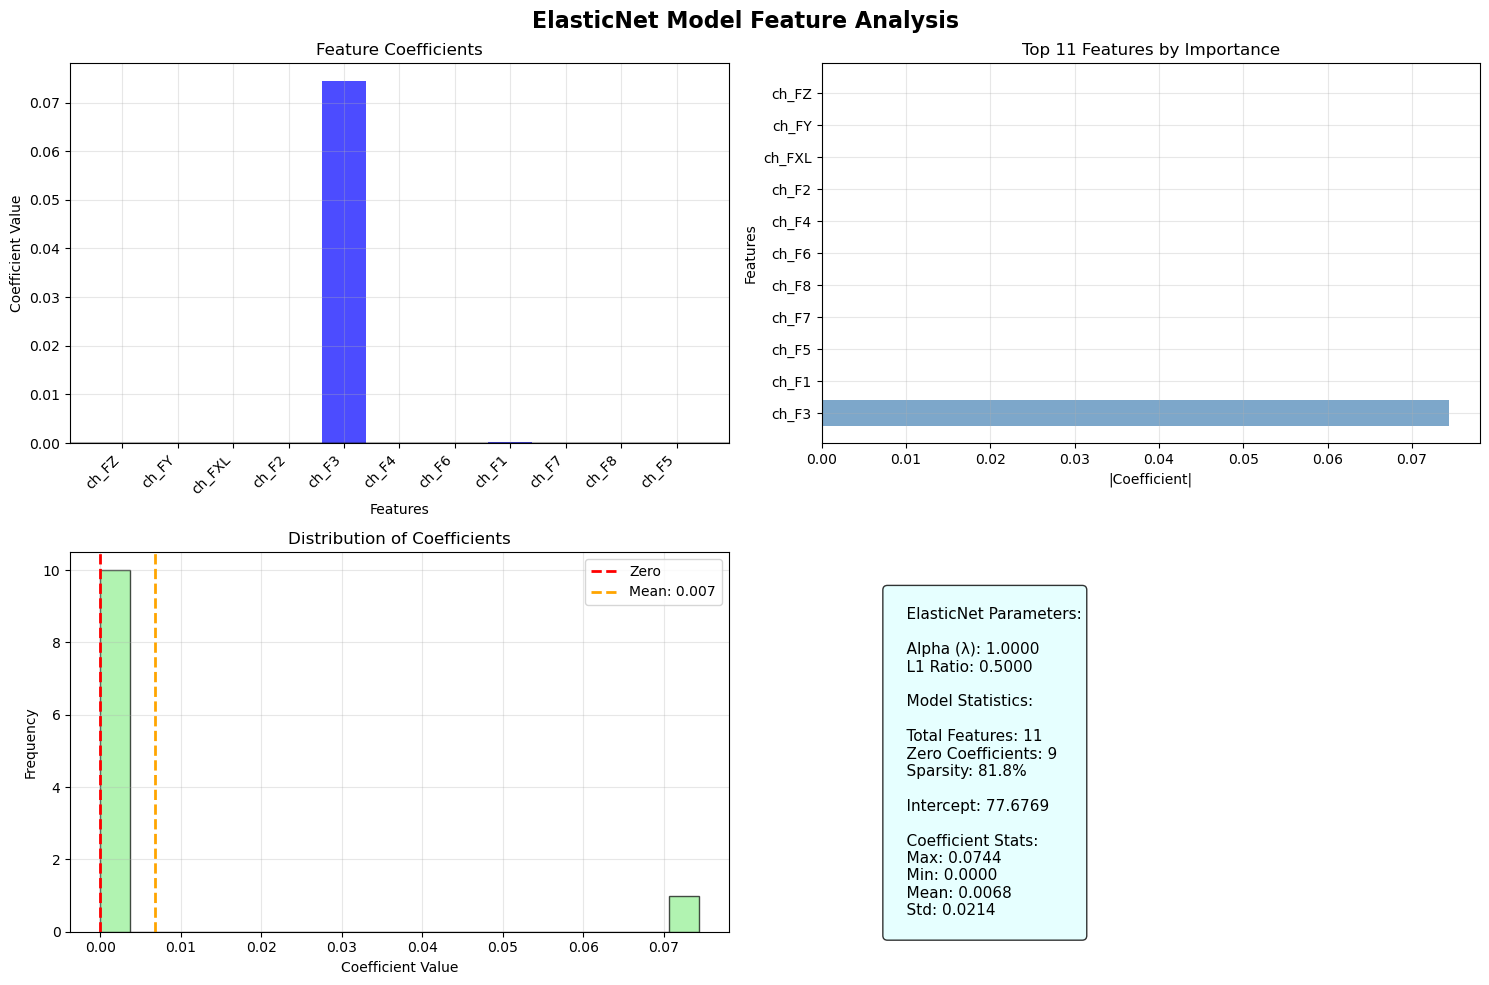

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
0,0.002069,0.001807,-61.435329,-57.753917,0.918553,0.903880
1,0.001674,0.001542,-59.833407,-58.793961,0.574400,0.921537
2,0.001709,0.001752,-57.767671,-59.061074,0.907076,0.917346
3,0.001658,0.001857,-107.191944,-51.796796,0.856878,0.926671
4,0.001851,0.001742,-55.974214,-59.483186,0.885683,0.919735


In [85]:

from sklearn.linear_model import ElasticNet

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
import numpy as np


def evaluate_pipeline(pipeline, X, y, cv=5, test_size=0.30, scoring=None, random_state=1):
    """Evaluate pipeline using cross_validate"""
    if scoring is None:
        scoring = ['neg_mean_absolute_error', 'r2']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    plot_evaluation(pipeline,  X_train, X_test, y_train, y_test)
    plot_model_features(pipeline,  X_train, feature_names=X.columns)
    
    return pandas.DataFrame(scores)


def create_pipeline():
    """Create sklearn pipeline with MinMaxScaler and ElasticNet"""
    pipeline = Pipeline([
        #('scaler', StandardScaler()),
        #('scaler', MinMaxScaler()),
        ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=10000, positive=True))
        #('regressor', RandomForestRegressor()),
    ])
    return pipeline

features = [ c for c in data.columns if 'ch_F' in c]
print(features)
#sub = avg[avg.colortemp == 2500]
sub = avg.copy()
X = sub[features]
y = sub['lux']

est = create_pipeline()

scores = evaluate_pipeline(est, X, y)

scores    

In [86]:
def plot_model_features(pipeline, X_train, feature_names=None, figsize=(15, 10)):
    """Plot feature coefficients and regularization analysis"""
    # Get the fitted ElasticNet model
    elasticnet = pipeline.named_steps['regressor']
    
    # Feature names
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(elasticnet.coef_))]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('ElasticNet Model Feature Analysis', fontsize=16, fontweight='bold')
    
    # 1. Feature coefficients bar plot
    ax1 = axes[0, 0]
    coef_abs = np.abs(elasticnet.coef_)
    colors = ['red' if c < 0 else 'blue' for c in elasticnet.coef_]
    bars = ax1.bar(range(len(elasticnet.coef_)), elasticnet.coef_, color=colors, alpha=0.7)
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Feature Coefficients')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    if len(feature_names) <= 20:
        ax1.set_xticks(range(len(feature_names)))
        ax1.set_xticklabels(feature_names, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Feature importance (absolute coefficients)
    ax2 = axes[0, 1]
    sorted_idx = np.argsort(coef_abs)[::-1]
    top_features = min(15, len(sorted_idx))  # Show top 15 features
    
    ax2.barh(range(top_features), coef_abs[sorted_idx[:top_features]], color='steelblue', alpha=0.7)
    ax2.set_xlabel('|Coefficient|')
    ax2.set_ylabel('Features')
    ax2.set_title(f'Top {top_features} Features by Importance')
    ax2.set_yticks(range(top_features))
    ax2.set_yticklabels([feature_names[i] for i in sorted_idx[:top_features]])
    ax2.grid(True, alpha=0.3)
    
    # 3. Coefficient distribution
    ax3 = axes[1, 0]
    ax3.hist(elasticnet.coef_, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    ax3.axvline(0, color='red', linestyle='--', lw=2, label='Zero')
    ax3.axvline(np.mean(elasticnet.coef_), color='orange', linestyle='--', lw=2, label=f'Mean: {np.mean(elasticnet.coef_):.3f}')
    ax3.set_xlabel('Coefficient Value')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Coefficients')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Model parameters and sparsity info
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate sparsity metrics
    zero_coef = np.sum(np.abs(elasticnet.coef_) < 1e-10)
    sparsity = zero_coef / len(elasticnet.coef_) * 100
    
    model_info = f"""
    ElasticNet Parameters:
    
    Alpha (λ): {elasticnet.alpha:.4f}
    L1 Ratio: {elasticnet.l1_ratio:.4f}
    
    Model Statistics:
    
    Total Features: {len(elasticnet.coef_)}
    Zero Coefficients: {zero_coef}
    Sparsity: {sparsity:.1f}%
    
    Intercept: {elasticnet.intercept_:.4f}
    
    Coefficient Stats:
    Max: {np.max(elasticnet.coef_):.4f}
    Min: {np.min(elasticnet.coef_):.4f}
    Mean: {np.mean(elasticnet.coef_):.4f}
    Std: {np.std(elasticnet.coef_):.4f}
    """
    
    ax4.text(0.1, 0.9, model_info, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'coefficients': elasticnet.coef_,
        'intercept': elasticnet.intercept_,
        'feature_importance': coef_abs,
        'sparsity_percent': sparsity,
        'zero_coefficients': zero_coef
    }

In [63]:
import matplotlib.pyplot as plt

def plot_evaluation(pipeline, X_train, X_test, y_train, y_test, figsize=(12, 8), error_threshold=50):
    """Create evaluation plots comparing train and test data"""
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Fit pipeline and predict
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calculate metrics
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Model Evaluation: Train vs Test Comparison', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted for both train and test
    ax1 = axes[0]
    
    # Plot training data
    ax1.scatter(y_train, y_pred_train, alpha=0.5, s=30, color='lightblue', 
                label=f'Train (R²={train_r2:.3f})', edgecolors='blue', linewidth=0.5)
    
    # Plot test data
    ax1.scatter(y_test, y_pred_test, alpha=0.7, s=50, color='orange', 
                label=f'Test (R²={test_r2:.3f})', edgecolors='red', linewidth=0.5)
    

    # Perfect prediction line
    all_values = np.concatenate([y_train, y_test, y_pred_train, y_pred_test])
    min_val, max_val = all_values.min(), all_values.max()
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect Prediction')
    
    # Reference lines at ±error_threshold
    ax1.plot([min_val, max_val], [min_val + error_threshold, max_val + error_threshold], 'g:', lw=1.5, alpha=0.7, label=f'+{error_threshold} Error')
    ax1.plot([min_val, max_val], [min_val - error_threshold, max_val - error_threshold], 'g:', lw=1.5, alpha=0.7, label=f'-{error_threshold} Error')

    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Actual vs Predicted')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuals plot for both train and test
    ax2 = axes[1]
    
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test
    
    ax2.scatter(y_pred_train, train_residuals, alpha=0.5, s=30, color='lightblue', 
                label='Train', edgecolors='blue', linewidth=0.5)
    ax2.scatter(y_pred_test, test_residuals, alpha=0.7, s=50, color='orange', 
                label='Test', edgecolors='red', linewidth=0.5)
    
    ax2.axhline(y=0, color='r', linestyle='--', lw=2, alpha=0.8)
    ax2.axhline(y=error_threshold, color='g', linestyle=':', lw=1.5, alpha=0.7, label=f'+{error_threshold} Error')
    ax2.axhline(y=-error_threshold, color='g', linestyle=':', lw=1.5, alpha=0.7, label=f'-{error_threshold} Error')
 
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals vs Predicted')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics comparison
    print("\nMetrics Comparison:")
    print(f"{'Metric':<25} {'Train':<12} {'Test':<12} {'Difference':<12}")
    print("-" * 65)
    print(f"{'R² Score':<25} {train_r2:<12.4f} {test_r2:<12.4f} {abs(train_r2-test_r2):<12.4f}")
    print(f"{'Mean Squared Error':<25} {train_mse:<12.4f} {test_mse:<12.4f} {abs(train_mse-test_mse):<12.4f}")
    print(f"{'RMSE':<25} {np.sqrt(train_mse):<12.4f} {np.sqrt(test_mse):<12.4f} {abs(np.sqrt(train_mse)-np.sqrt(test_mse)):<12.4f}")
    print(f"{'Mean Absolute Error':<25} {mean_absolute_error(y_train, y_pred_train):<12.4f} {test_mae:<12.4f} {abs(mean_absolute_error(y_train, y_pred_train)-test_mae):<12.4f}")
    print(f"{'Sample Size':<25} {len(y_train):<12} {len(y_test):<12}")
    
    return {
        'train': {'r2': train_r2, 'mae': train_mae, 'rmse': np.sqrt(train_mse)},
        'test': {'r2': test_r2, 'mae': test_mae, 'rmse': np.sqrt(test_mse)}
    }


Wrote one_averaged.png


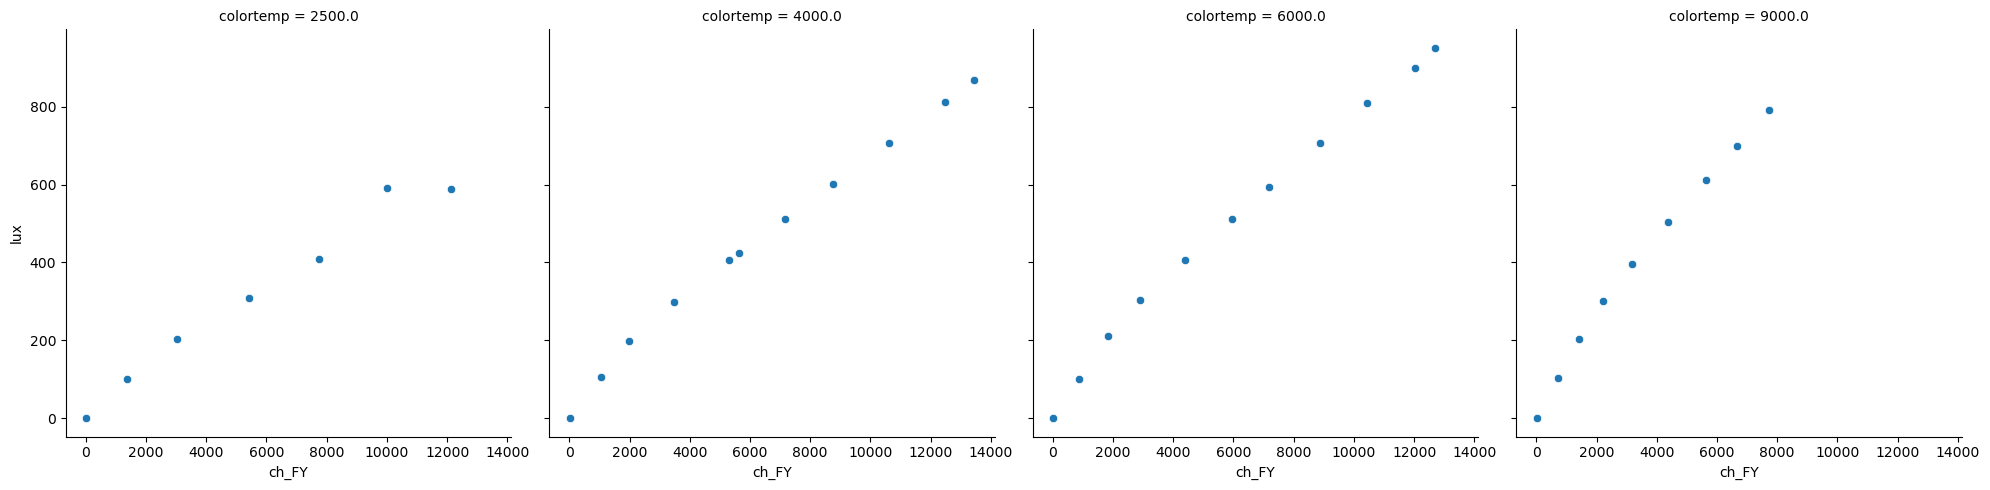

In [41]:
g = seaborn.relplot(data=avg, x='ch_FY', y='lux', col='colortemp')
fig = g.figure
plot_path = 'one_averaged.png'
fig.savefig(plot_path)
print('Wrote', plot_path)

In [8]:
data.columns

Index(['ch_FZ', 'ch_FY', 'ch_FXL', 'ch_NIR', 'ch_VIS1_TL', 'ch_VIS1_BR',
       'ch_F2', 'ch_F3', 'ch_F4', 'ch_F6', 'ch_VIS2_TL', 'ch_VIS2_BR', 'ch_F1',
       'ch_F7', 'ch_F8', 'ch_F5', 'ch_VIS3_TL', 'ch_VIS3_BR', 'datapoint',
       'filename', 'experiment', 'lux', 'colortemp'],
      dtype='object')

In [8]:
mpsklearn.metrics.get_scorer_names()

NameError: name 'sklearn' is not defined